## Import libraries

In [1]:
import os
import numpy as np
import pandas as pd
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

## Prepare/Read Dataset
The original dataset is a set of JPG images in three directories called,

- Potato__Early_blight
- Potato__healthy
- Potato__Late_blight

In [2]:
input_base_path = "working/input"
def dir_to_list(directory_name:'str'):
    files = os.listdir(os.path.join(input_base_path, str(directory_name)))
    return files
def health_list_function(potato_list:'list', condition:'str'): 
    return list(map(lambda x : condition, potato_list))
# notebook_path = os.listdir('input/Potato___Early_blight')
# print(notebook_path)

In [3]:
state_names = ["Potato___Early_blight", "Potato___healthy", "Potato___Late_blight"]
state_mapping = {"early_blight" : "Potato___Early_blight", "healthy" : "Potato___healthy", "late_blight" : "Potato___Late_blight"}
early_blight_filename_list = dir_to_list(state_mapping["early_blight"])
healthy_filename_list = dir_to_list(state_mapping["healthy"])
late_blight_filename_list = dir_to_list(state_mapping["late_blight"])
# healthy_df = pd.DataFrame(dir_to_list(Potato___healthy), healthy)
# late_blight_df = pd.DataFrame(dir_to_list(Potato___Late_blight), Potato___Late_blight)

In [4]:
early_blight_condition_list = health_list_function(early_blight_filename_list, state_mapping['early_blight'])
healthy_condition_list = health_list_function(healthy_filename_list, state_mapping['healthy'])
late_blight_condition_list = health_list_function(late_blight_filename_list, state_mapping['late_blight'])

In [5]:
early_blight_df = pd.DataFrame(data = {'Filename' : early_blight_filename_list, 'Health_Condition' : early_blight_condition_list})
healthy_df = pd.DataFrame(data = {'Filename' : healthy_filename_list, 'Health_Condition' : healthy_condition_list})
late_blight_df = pd.DataFrame(data = {'Filename' : late_blight_filename_list, 'Health_Condition' : late_blight_condition_list})

In [6]:
print(early_blight_df.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 2 entries, Filename to Health_Condition
dtypes: object(2)
memory usage: 15.8+ KB
None


In [7]:
print(healthy_df.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 152 entries, 0 to 151
Columns: 2 entries, Filename to Health_Condition
dtypes: object(2)
memory usage: 2.5+ KB
None


In [8]:
print(late_blight_df.info(verbose = False))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 2 entries, Filename to Health_Condition
dtypes: object(2)
memory usage: 15.8+ KB
None


In [9]:
frames = [early_blight_df, healthy_df, late_blight_df]
potato_df = pd.concat(frames, ignore_index=True)

In [10]:
print(potato_df.info(verbose = True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2152 entries, 0 to 2151
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Filename          2152 non-null   object
 1   Health_Condition  2152 non-null   object
dtypes: object(2)
memory usage: 33.8+ KB
None


## Properties of image files

### Check basic properties of first image file

In [11]:
image_filename = potato_df['Filename'][0]
image_condition = potato_df['Health_Condition'][0]
image_path = os.path.join(input_base_path, image_condition, image_filename)
print(image_path)
image = cv.imread(image_path)
height, width, channels = image.shape
print(f'height:{height} width:{width} channel:{channels}')

working/input\Potato___Early_blight\001187a0-57ab-4329-baff-e7246a9edeb0___RS_Early.B 8178.JPG
height:256 width:256 channel:3


### Check if any of the image files are sized differently from the first

In [12]:
for row in potato_df.itertuples():
    dims0 = (256, 256, 3)
    image_path = os.path.join(input_base_path, row.Health_Condition, row.Filename)
    image = cv.imread(image_path)
    dims = image.shape
    if dims == dims0:
        continue
    else:
        print(f'Warning: Dimension of following file does not match: {image_path}\n')
        continue

## Creating Test/Train Directories

In [13]:
output_base_path = "working/model_data"
train_dir = os.path.join(output_base_path, "train")
test_dir = os.path.join(output_base_path, "test")

os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# state_names = potato_df['Health_Condition'].unique()
# print(potato_df[potato_df['Health_Condition']==state_mappings['early_blight']]['Filename'])
# print(state_names[0])
# print(potato_df['Health_Condition'])
for state, value in state_mapping.items():
    os.makedirs(os.path.join(train_dir, value), exist_ok = True)
    os.makedirs(os.path.join(test_dir, value), exist_ok = True)

## Sorting Data into Test/Train Directories

In [14]:
def sort_and_copy_data(test_size = 0.2, random_state = 42):
    """
        Splits and copies images into training and testing directories
        Args:
            test_size: Proportion of images to allocate for testing the model (0.0 - 1.0)
            random_state: Seed value used to split images into training and test directories
    """
    #Tracks number of images for each state
    state_counts = {state: 0 for state in state_mapping.keys()}
    test_counts = {state: 0 for state in state_mapping.keys()}
    train_counts = {state: 0 for state in state_mapping.keys()}

    for state, value in state_mapping.items():
        files = potato_df[potato_df['Health_Condition']==value]['Filename']
        state_counts[state] += files.shape[0]
        
        #Splits the images into train and test directories
        train_files, test_files = train_test_split(files, test_size = test_size, random_state = random_state)
        for file in train_files:
            source_dir = os.path.join(input_base_path, value, file)
            destination_dir = os.path.join(train_dir, value, file)
            shutil.copy2(source_dir, destination_dir)
            train_counts[state] += 1
            
        for file in test_files:
            source_dir = os.path.join(input_base_path, value, file)
            destination_dir = os.path.join(test_dir, value, file)
            shutil.copy2(source_dir, destination_dir)
            test_counts[state] += 1

    return state_counts, train_counts, test_counts
            
    

In [15]:
state_counts, train_counts, test_counts = sort_and_copy_data()

## Visualize Test/Train Distribution 

In [16]:
print('Data Set Distribution:')
print('-'*50)
print(f'{'State':<15}{'Total':<10}{'Train':<10}{'Test'}')
print('-'*50)
for keys, values in state_mapping.items():
    print(f'{keys:<15}{state_counts[keys]:<10}{train_counts[keys]:<10}{test_counts[keys]}')
    
total_train = sum(train_counts.values())
total_test = sum(test_counts.values())
total = total_train + total_test

print(f'{'Total':<15}{total:<10}{total_train:<10}{total_test}')


Data Set Distribution:
--------------------------------------------------
State          Total     Train     Test
--------------------------------------------------
early_blight   1000      800       200
healthy        152       121       31
late_blight    1000      800       200
Total          2152      1721      431


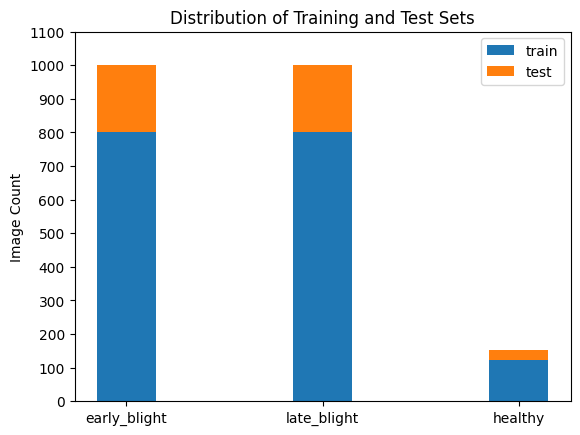

In [17]:
states = list(state_mapping.keys())
states = states[0:3:2] + [states[1]]
train_population = [train_counts[keys] for keys in states]
test_population = [test_counts[keys] for keys in states]
N = np.arange(len(states))
width = 0.3

fig = plt.subplots()
train_bar = plt.bar(N, train_population, width)
test_bar = plt.bar(N, test_population, width, bottom = train_population)

plt.ylabel("Image Count")
plt.xticks(N, states)
plt.yticks(np.arange(0, 1101, 100))
plt.legend((train_bar, test_bar),('train', 'test'))
plt.title('Distribution of Training and Test Sets')

plt.show()

## Load Train/Test data

In [18]:
print(train_dir)
print(test_dir)

working/model_data\train
working/model_data\test


In [19]:
height = 256
width = 256
batch_size = 32
class_names = list(state_mapping.values())
class_names = class_names[0:3:2] + [class_names[1]] #early_blight, late_blight, healthy

#keras function returns batch of images with a label corresponding to the state (class) of the images
#described in detail here: https://keras.io/api/data_loading/image/
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir, 
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = class_names,
    batch_size = batch_size,
    image_size = (height, width),
    shuffle = True,
    interpolation = 'nearest',
    verbose = False
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, 
    labels = 'inferred',
    label_mode = 'categorical',
    class_names = class_names,
    batch_size = batch_size,
    image_size = (height, width),
    shuffle = True,
    interpolation = 'nearest',
    verbose = False
)

## Image Normalization
I want to try several different models and so will normalize the data instead of explicitly doing so in each model (ie normalization layers).

In [20]:
def normalize_img(image, label):
    """
    normalizes pixel values from 0-255 to 0-1
    """
    image_norm = tf.cast(image, tf.float32) / 255.0
    
    return image_norm, label

train_ds = train_ds.map(normalize_img)
test_ds = test_ds.map(normalize_img)

## Optimize Runtime of Dataset 

In [21]:
AUTOTUNE = tf.data.AUTOTUNE

#Caching
train_ds = train_ds.cache()
test_ds = test_ds.cache()

#Prefetching
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)


## Custom Model

Input -> CV(relu) -> CV(relu) -> CV(relu) -> FC(relu) -> DP(0.5) -> FC(relu) -> DP(0.5) -> FC(relu) -> DP(0.5) -> FC(SoftMax)


In [22]:
height = 256
width = 256
channels = 3
num_state = 3 #healthy, early_blight, late_blight

model1 = Sequential([
    Input(shape = (height, width, channels)),
    
    Conv2D(filters=32, kernel_size=(3,3), strides=1, padding='valid', data_format='channels_last', activation='relu', use_bias = True),
    MaxPooling2D(pool_size=(2,2), strides=None),
    
    Conv2D(filters=64, kernel_size=(3,3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    
    Conv2D(filters=128, kernel_size=(3,3), strides=1, activation='relu'),
    MaxPooling2D(pool_size=(2,2)),

    Flatten(),

    Dense(units=512, activation='relu', use_bias=True),
    Dropout(0.5),
    
    Dense(units=256, activation='relu'),
    Dropout(0.5),

    Dense(units=128, activation='relu'),
    Dropout(0.5),
    
    Dense(units=num_state, activation='softmax')
])

model1.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,982,912 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 59,240,771 (225.99 MB)

 Trainable params: 59,240,771 (225.99 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
train_counts_early_blight = 1/train_counts['early_blight']
train_counts_late_blight = 1/train_counts['late_blight']
train_counts_healthy = 1/train_counts['healthy']
total_train = sum(train_counts.values())
class_weight = {0 : (1/train_counts_early_blight) * (total_train/3.0), 
                1 : (1/train_counts_late_blight) * (total_train/3.0), 
                2 : (1/train_counts_healthy) * (total_train/3.0)
               }
history1 = model1.fit(
    train_ds,
    validation_data=test_ds,
    callbacks = EarlyStopping(monitor = 'val_loss', patience = 5),
    class_weight = class_weight,
    shuffle = True,
    epochs = 50,
    verbose = 1
)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 753ms/step - accuracy: 0.4476 - loss: 570572.6875 - val_accuracy: 0.7425 - val_loss: 0.8415
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 42s 769ms/step - accuracy: 0.7150 - loss: 235441.3594 - val_accuracy: 0.8353 - val_loss: 0.5520
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 696ms/step - accuracy: 0.8658 - loss: 120102.5469 - val_accuracy: 0.8283 - val_loss: 0.5900
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 39s 713ms/step - accuracy: 0.8676 - loss: 106657.3516 - val_accuracy: 0.8770 - val_loss: 0.4110
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 742ms/step - accuracy: 0.9038 - loss: 61613.7930 - val_accuracy: 0.8956 - val_loss: 0.3047
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 731ms/step - accuracy: 0.8991 - loss: 56555.0820 - val_accuracy: 0.8654 - val_loss: 0.4132
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 38s 705ms/step - accuracy: 0.8993 - loss: 55311.1680 - val_accuracy: 0.8910 - val_loss: 0.3465
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 753ms/step - accuracy: 

In [24]:
results_model1 = pd.DataFrame(history1.history)
results_model1

,accuracy,loss,val_accuracy,val_loss
0,0.472400,416203.125000,0.742459,0.841545
1,0.780360,192901.406250,0.835267,0.552026
2,0.868100,117760.093750,0.828306,0.590001
3,0.879140,98017.937500,0.877030,0.410956
4,0.907031,61180.351562,0.895592,0.304692
5,0.897153,67516.039062,0.865429,0.413214
6,0.903544,56504.406250,0.890951,0.346517
7,0.914585,41331.562500,0.902552,0.275890
8,0.916909,38997.085938,0.853828,0.333227
9,0.916328,41324.257812,0.881671,0.293613


In [25]:
model1_accuracy = results_model1['accuracy'].values
model1_loss = results_model1['loss'].values
model1_val_accuracy = results_model1['val_accuracy'].values
model1_val_loss = results_model1['val_loss'].values
model1_epochs = range(len(model1_accuracy))

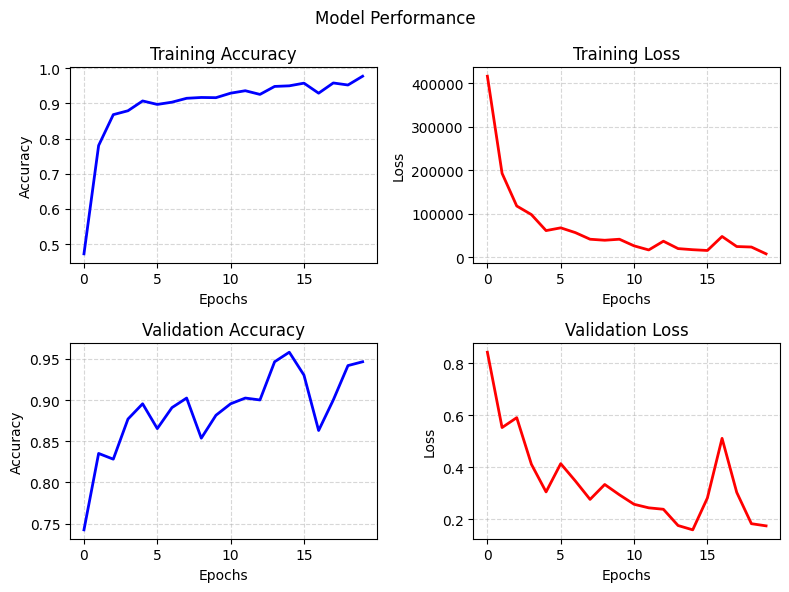

In [26]:
plt.figure(figsize = (8, 6))
plt.subplot(2,2,1)
plt.plot(model1_epochs, model1_accuracy, 'b-', linewidth=2,  label = 'model1')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,2)
plt.plot(model1_epochs, model1_loss, 'r-', linewidth=2,  label = 'model1')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,3)
plt.plot(model1_epochs, model1_val_accuracy, 'b-', linewidth=2,  label = 'model1')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)

plt.subplot(2,2,4)
plt.plot(model1_epochs, model1_val_loss, 'r-', linewidth=2, label = 'model1')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)

plt.suptitle("Model Performance")
plt.tight_layout()
plt.show()

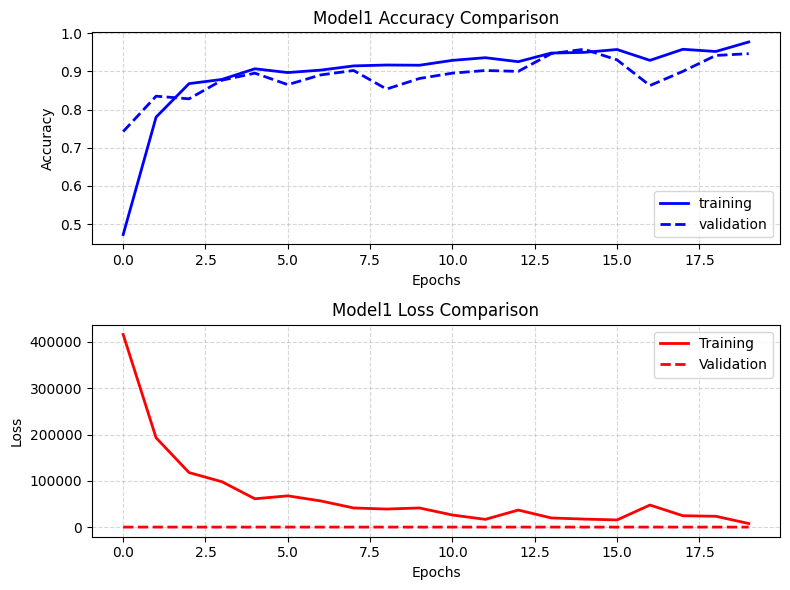

In [27]:
plt.figure(figsize = (8, 6))
plt.subplot(2, 1, 1)
plt.plot(model1_epochs, model1_accuracy, 'b-', linewidth=2,  label = 'training')
plt.plot(model1_epochs, model1_val_accuracy, 'b--', linewidth=2,  label = 'validation')
plt.title("Model1 Accuracy Comparison")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='lower right')

plt.subplot(2, 1, 2)
plt.plot(model1_epochs, model1_loss, 'r-', linewidth=2,  label = 'Training')
plt.plot(model1_epochs, model1_val_loss, 'r--', linewidth=2,  label = 'Validation')
plt.title("Model1 Loss Comparison")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(loc='upper right')

plt.tight_layout()

plt.show()

In [28]:
Validation_test = model1.predict(test_ds)

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step


In [29]:
Validation_prediction = np.argmax(Validation_test, axis = -1)

In [30]:
Validation_reference=[]
for images, labels in test_ds.unbatch():
    Validation_reference.append(int(np.argmax(labels.numpy()))) # or 
Validation_reference = np.array(Validation_reference)

In [31]:
conf_matrix = confusion_matrix( Validation_reference, Validation_prediction)
conf_matrix_norm_true = confusion_matrix(Validation_reference, Validation_prediction, normalize = 'true')
conf_matrix_norm_pred = confusion_matrix(Validation_reference, Validation_prediction, normalize = 'pred')

print(conf_matrix)
print(conf_matrix_norm_true*100)
print(conf_matrix_norm_pred*100)

[[197   1   2]
 [ 11 183   6]
 [  0   3  28]]
[[98.5         0.5         1.        ]
 [ 5.5        91.5         3.        ]
 [ 0.          9.67741935 90.32258065]]
[[94.71153846  0.53475936  5.55555556]
 [ 5.28846154 97.86096257 16.66666667]
 [ 0.          1.60427807 77.77777778]]


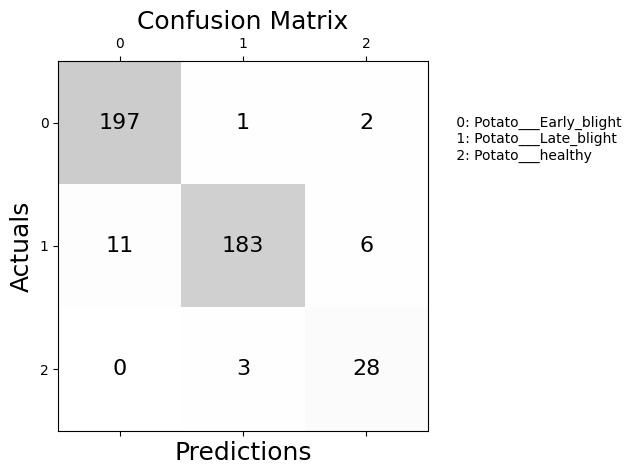

In [32]:
fig, ax = plt.subplots()
ax.matshow(conf_matrix, cmap = 'Greys', alpha = 0.2)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i, s=f'{conf_matrix[i,j]}', va='center', ha='center', fontsize = '16')
ax.text(x=2.7, y=0.3, s=f' 0: {class_names[0]}\n 1: {class_names[1]} \n 2: {class_names[2]}')
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()